In [25]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset
import os



dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])


In [26]:
train_answers_2 = np.load("gsm8k_train_questions_new_gpt4o.npy")

In [52]:
def get_stats(train_name):
    num_memorized_all = []
    num_correct_different_all = []
    num_incorrect_all = []
    perplexities_all = []


    # if "Qwen" in train_name and "3epochs" in train_name:
    #     ckpts = ["62", "124", "186"] 
    # elif "Qwen" in train_name and "6epochs" in train_name:
    #     ckpts = ["62", "124", "186", "249", "311", "372"] 
    # elif "6epochs_half" in train_name:
    #     ckpts = ["29", "58", "87", "116", "145", "174"]
    # elif "3epochs_half" in train_name:
    #     ckpts = ["29", "58", "87"]
    # elif "12epochs_quarter" in train_name:
    #     ckpts = ["29", "58", "87", "116", "145"]
    # elif "24epochs_eighth" in train_name:
    #     ckpts = ["29", "58", "87", "116", "145"]
    # elif "_6epochs" in train_name:
    #     ckpts = ["58", "116", "175", "233", "292", "348"]
    # elif "_12epochs" in train_name:
    #     ckpts = ["116", "232", "348", "464", "580", "696"]
    # elif "_1epochs" in train_name:
    #     ckpts = ["58"]
    # elif "_3epochs" in train_name:
    #     ckpts = ["58", "116", "174"]
        
    # ckpts = os.listdir("ckpts/"+train_name)
    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))
    print(ckpts)

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2.npy")==0)
            train_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answers5_seed2.npy"))
        except:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            train_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answers5_seed2_temp0.8.npy"))
            
        if "half" in train_name:
            subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
            train_correct = train_correct[subsample_idxs]
            train_samples = train_samples[subsample_idxs]
        else:
            subsample_idxs = np.arange(len(train_answers))

        num_memorized_ckpt = []
        num_correct_different_ckpt = []
        num_incorrect_ckpt = []

        for input_idx in range(len(subsample_idxs)):
            num_memorized = 0
            num_correct_different = 0
            num_incorrect = 0
            for sample_idx in range(5):
                correct = train_correct[input_idx, sample_idx]
                if correct:
                    if (train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip()) or (train_samples[input_idx][sample_idx].strip() == train_answers_2[subsample_idxs[input_idx]].strip()):
                        num_memorized+=1
                    else:
                        num_correct_different+=1
                else:
                    num_incorrect+=1 
            num_memorized_ckpt.append(num_memorized)
            num_correct_different_ckpt.append(num_correct_different)
            num_incorrect_ckpt.append(num_incorrect)
        
        num_memorized_all.append(num_memorized_ckpt)
        num_correct_different_all.append(num_correct_different_ckpt)
        num_incorrect_all.append(num_incorrect_ckpt)
        
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")[subsample_idxs]
        perplexities_all.append(perplexities)
        
    num_memorized_all = np.array(num_memorized_all)
    num_correct_different_all = np.array(num_correct_different_all)
    num_incorrect_all = np.array(num_incorrect_all)
    perplexities_all = np.array(perplexities_all)
    
    test_accs_all = []
    # test_samples_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2.npy")==0)
            test_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answers50_seed2.npy"))
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
                test_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answers50_seed2_temp0.8.npy"))
            except:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
                test_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answers5_seed2_temp0.8.npy"))
        
    #     test_samples_strip = []
    #     for sample_list in test_samples:
    #         sample_list_strip = np.array([sample.strip() for sample in sample_list])
    #         test_samples_strip.append(sample_list_strip)
    #     test_samples = np.array(test_samples_strip)
            
        test_accs_all.append(test_accs)
    #     test_samples_all.append(test_samples)

    test_accs_all = np.array(test_accs_all)
    # test_samples_all = np.array(test_samples_all)
    
    return_dict = {}
    return_dict["num_memorized_all"] = num_memorized_all
    return_dict["num_correct_different_all"] = num_correct_different_all
    return_dict["num_incorrect_all"] = num_incorrect_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    # return_dict["test_samples_all"] = test_samples_all
    
    return return_dict



In [53]:
stats_dict5_3_full = get_stats("gsm8k_orig_3epochs_full_lr5e-05_bs128")
stats_dict5_3_add_memorized = get_stats("gsm8k_orig_3epochs_add_memorized_lr5e-05_bs128")
stats_dict5_3_add_rand = get_stats("gsm8k_orig_3epochs_add_rand_lr5e-05_bs128")


['checkpoint-58', 'checkpoint-116', 'checkpoint-174']
['checkpoint-83', 'checkpoint-167', 'checkpoint-249']
['checkpoint-83', 'checkpoint-167', 'checkpoint-249']


In [74]:

def get_ratios(stats_dict, acc_threhshold, perp_threshold):
    num_incorrect_all = stats_dict["num_incorrect_all"]
    num_memorized_all = stats_dict["num_memorized_all"]
    num_correct_different_all = stats_dict["num_correct_different_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    # test_samples_all = stats_dict["test_samples_all"]
    
    example_type = np.ones(num_incorrect_all.shape)*-1

    for i in range(len(num_memorized_all)):
        incorrect_idxs = np.where(num_memorized_all[i]+num_correct_different_all[i] < acc_threhshold)[0]
        correct = (num_memorized_all[i]+num_correct_different_all[i] >= acc_threhshold)
        example_type[i][incorrect_idxs] = 0 #incorrect 
        
        

        unmemorized_idxs = np.where((correct) * (num_memorized_all[i]<=0.5))[0]
        # unmemorized_idxs = np.where((correct) * (np.log(np.log((perplexities_all[i]))) >= perp_threshold))[0]
        example_type[i][unmemorized_idxs] = 1 #unmemorized
        
        memorized_idxs = np.where((correct) * (num_memorized_all[i]>=0.5))[0]
        # memorized_idxs = np.where((correct) * (np.log(np.log((perplexities_all[i]))) <= perp_threshold))[0]
        prev_unmemorized_idxs = np.where((example_type[:i]==1).sum(axis=0)>0)[0]
        
        memorized1_idxs = np.intersect1d(memorized_idxs, prev_unmemorized_idxs)
        memorized2_idxs = np.setdiff1d(memorized_idxs, prev_unmemorized_idxs)
        
        example_type[i][memorized1_idxs] = 2 #memorized
        example_type[i][memorized2_idxs] = 3 #memorized
        
    
    
    # return example_type
    # make 2 subplots
    ratio_incorrect = (example_type == 0).mean(axis=1)
    ratio_unmemorized = (example_type == 1).mean(axis=1)
    ratio_memorized1 = (example_type == 2).mean(axis=1)
    ratio_memorized2 = (example_type == 3).mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    
    
    return_dict = {}
    
    return_dict["ratio_incorrect"] = ratio_incorrect
    return_dict["ratio_unmemorized"] = ratio_unmemorized
    return_dict["ratio_memorized1"] = ratio_memorized1
    return_dict["ratio_memorized2"] = ratio_memorized2
    return_dict["avg_test_acc"] = avg_test_acc
    # return_dict["maj_50"] = maj_50
            
    return return_dict, example_type




In [75]:
acc_threhshold = 2.5 
perp_threshold = -2.5

return_dict_full, example_type_full = get_ratios(stats_dict5_3_full, acc_threhshold, perp_threshold)
return_dict_add_memorized, example_type_add_memorized = get_ratios(stats_dict5_3_add_memorized, acc_threhshold, perp_threshold)
return_dict_add_rand, example_type_add_rand = get_ratios(stats_dict5_3_add_rand, acc_threhshold, perp_threshold)


In [76]:
full_memorized_idxs = np.load("ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/memorized_idxs.npy")

In [87]:
((example_type_full==3)[-1, full_memorized_idxs]).mean()
((example_type_full==3)[-1, full_unmemorized_idxs]).mean()

0.008559201141226819

In [86]:
full_unmemorized_idxs = np.setdiff1d(np.arange(len(train_answers)), full_memorized_idxs)

In [88]:
((example_type_add_memorized==3)[-1, full_memorized_idxs]).mean()
((example_type_add_memorized==3)[-1, full_unmemorized_idxs]).mean()

0.1459819305753685

In [89]:
((example_type_add_rand==3)[-1, full_memorized_idxs]).mean()
((example_type_add_rand==3)[-1, full_unmemorized_idxs]).mean()

0.13338088445078458

In [78]:
return_dict_add_memorized

{'ratio_incorrect': array([0.52910478, 0.26013649, 0.06048441]),
 'ratio_unmemorized': array([0.46259869, 0.58892011, 0.23631741]),
 'ratio_memorized1': array([0.        , 0.10236853, 0.54837415]),
 'ratio_memorized2': array([0.00829653, 0.04857487, 0.15482403]),
 'avg_test_acc': array([0.38695982, 0.48567096, 0.52084913])}

In [79]:
return_dict_add_rand

{'ratio_incorrect': array([0.56443196, 0.29211829, 0.07346447]),
 'ratio_unmemorized': array([0.42499665, 0.56764352, 0.23752174]),
 'ratio_memorized1': array([0.        , 0.08564164, 0.51037067]),
 'ratio_memorized2': array([0.01057139, 0.05459655, 0.17864312]),
 'avg_test_acc': array([0.36103108, 0.46686884, 0.51478393])}

In [123]:
(np.load("ckpts/gsm8k_orig_3epochs_add_memorized_orig_lr5e-05_bs128/checkpoint-167/test_answer_types5_seed2_temp0.8.npy")==0).mean()

0.4392721758908264

In [80]:
return_dict_full

{'ratio_incorrect': array([0.64458718, 0.31566974, 0.14010438]),
 'ratio_unmemorized': array([0.32289576, 0.38699318, 0.22400642]),
 'ratio_memorized1': array([0.        , 0.13033588, 0.36384317]),
 'ratio_memorized2': array([0.03251706, 0.1670012 , 0.27204603]),
 'avg_test_acc': array([0.28571645, 0.4121304 , 0.45332828])}

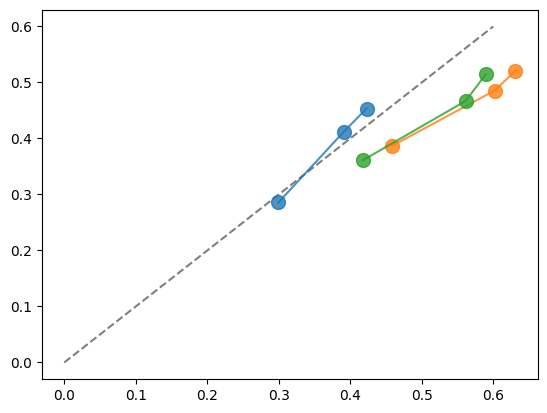

In [23]:
plt.plot([0, 0.6], [0, 0.6], "--", color="black", alpha=0.5)


plt.plot(return_dict_full["ratio_memorized1"]+return_dict_full["ratio_unmemorized"], return_dict_full["avg_test_acc"], "o-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 6")
plt.plot(return_dict_add_memorized["ratio_memorized1"]+return_dict_add_memorized["ratio_unmemorized"], return_dict_add_memorized["avg_test_acc"], "o-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 6")
plt.plot(return_dict_add_rand["ratio_memorized1"]+return_dict_add_rand["ratio_unmemorized"], return_dict_add_rand["avg_test_acc"], "o-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 6")

In [18]:
np.save("ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/memorized_idxs.npy", np.where(example_type[-1]==3)[0])

In [19]:
len(np.where(example_type[-1]==3)[0])

3267

[]

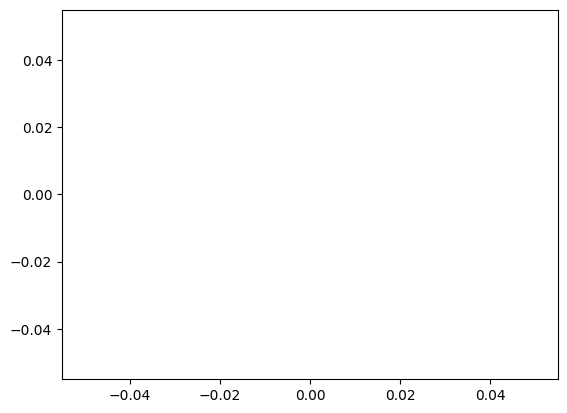

In [3]:
import matplotlib.pyplot as plt
plt.plot()

In [112]:
max_log_log_perp_1 = np.ones(7473)*-20

for checkpoints in ["58", "116", "175", "233", "292", "348"]:
    train_accs = (np.load("ckpts/gsm8k_orig_6epochs_full_lr0.0002_bs128/checkpoint-"+checkpoints+"/train_answer_types5_seed2.npy")==0).sum(axis=1)
    perp = np.load("ckpts/gsm8k_orig_6epochs_full_lr0.0002_bs128/checkpoint-"+checkpoints+"/train_perplexities.npy")
    
    for i in range(7473):
        if train_accs[i] >= 2.5:
            max_log_log_perp_1[i] = max(max_log_log_perp_1[i], np.log(np.log(perp[i])))

In [113]:
max_log_log_perp_2 = np.ones(7473)*-20

for checkpoints in ["58", "116", "175", "233", "292", "348"]:
    train_accs = (np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-05_bs128/checkpoint-"+checkpoints+"/train_answer_types5_seed2_temp0.8.npy")==0).sum(axis=1)
    perp = np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-05_bs128/checkpoint-"+checkpoints+"/train_perplexities.npy")
    
    for i in range(7473):
        if train_accs[i] >= 2.5:
            max_log_log_perp_2[i] = max(max_log_log_perp_2[i], np.log(np.log(perp[i])))

(-12.0, 1.0)

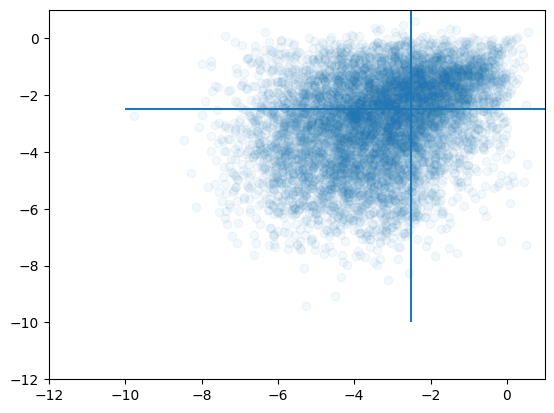

In [116]:
plt.scatter(max_log_log_perp_1, max_log_log_perp_2, alpha=0.05)
plt.hlines(-2.5, -10, 1)
plt.vlines(-2.5, -10, 1)


plt.xlim(-12, 1)
plt.ylim(-12, 1)